In [49]:
from env import SalesEnv
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [25]:
env = SalesEnv(50,15)

In [37]:
class OffPolicyMCAgent:

    def __init__(self, env, gamma=1):
        self.env = env
        self.q_table = np.random.random((len(env.state_space), len(env.action_space)))
        self.gamma = gamma
        max = np.argmax(self.q_table, axis=1)
        self.pi = np.zeros((len(env.state_space),len(env.action_space)))
        for i in range(len(env.state_space)):
            self.pi[i,max[i]] = 1
        # Generate random positive numbers and normalize to create a valid probability distribution
        self.b = np.random.uniform(0.1, 1.0, (len(env.state_space), len(env.action_space)))
        self.b = self.b / self.b.sum(axis=1)[:, np.newaxis]
        self.encountered_states = set()
        
        self.train()

    def generate_episode(self):
        episode = []
        state = self.env.reset()
        while True:
            state_index = self.env.state_space.index(state)
            action = np.random.choice(self.env.action_space, p=self.b[state_index])
            next_state, reward, done = self.env.step(action)  # Unpack the result directly
            episode.append((state, action, reward))
            state = next_state.copy()  # Make sure to create a copy of the state
            if done:
                break
              # Use the new state directly
        return episode


    def train(self,num_episodes = 1000000):
        c = np.zeros((len(self.env.state_space), len(self.env.action_space)))
        for i in tqdm.tqdm(range(num_episodes)):
            episode = self.generate_episode()
            g = 0
            w = 1
            for state, action, reward in reversed(episode):
                # Get state and action index for the current state
                state_index = self.env.state_space.index(state)
                action_index = self.env.action_space.index(action)
                self.encountered_states.add(state_index)
                g = self.gamma * g + reward
                c[state_index, action_index] += w
                self.q_table[state_index, action_index] += ( w / c[state_index, action_index]) * (g - self.q_table[state_index, action_index])

                # Update policy
                max = np.argmax(self.q_table[state_index])
                self.pi[state_index,:] = np.zeros(len(self.env.action_space))
                self.pi[state_index,max] = 1

                if action != np.argmax(self.pi[state]):
                    break
                w = w / self.b[state_index, action_index]





    


In [38]:
agent = OffPolicyMCAgent(env)

100%|██████████| 1000000/1000000 [02:33<00:00, 6498.29it/s]


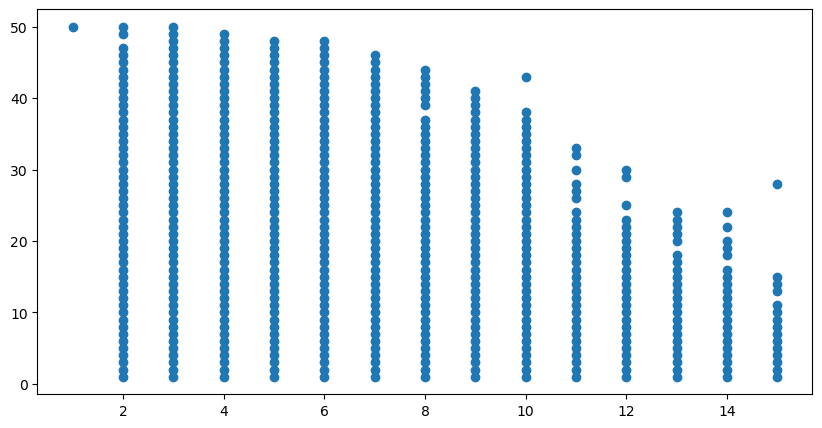

In [54]:
inventory = []
time = []
for i in list(agent.encountered_states):
    state = env.state_space[i]
    inventory.append(state[0])
    time.append(state[1])
plt.figure(figsize=(10,5))
plt.scatter(time,inventory)